### Stock Market Prediction And Forecasting Using Stacked LSTM

In [ ]:
#Import libraries
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM



In [ ]:
#Data Collection

key = '891291f4c52ecfb595cbcee737aa883611e6479e'
df = pdr.get_data_tiingo('MSFT', api_key=key)

In [ ]:
#df.to_csv('FB.csv')
#df=pd.read_csv('FB.csv')

In [ ]:
#df.head()
#df.tail()
#df.describe()

In [ ]:
df1=df.reset_index()['close']

Text(0, 0.5, 'Price')

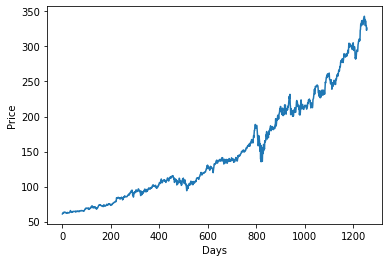

In [ ]:
plt.plot(df1)
plt.xlabel('Days')
plt.ylabel('Price')

In [ ]:
df1

0        61.01
1        61.97
2        62.17
3        62.98
4        62.68
         ...  
1252    330.59
1253    330.08
1254    329.49
1255    323.01
1256    326.19
Name: close, Length: 1257, dtype: float64

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
#print(df1)

In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
#training_size,test_size

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(339, 100)
(339,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model


In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 318ms/step - loss: 0.0118 - val_loss: 0.0976
Epoch 2/100
12/12 [==============================] - 2s 202ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 3/100
12/12 [==============================] - 2s 201ms/step - loss: 6.0177e-04 - val_loss: 0.0129
Epoch 4/100
12/12 [==============================] - 2s 202ms/step - loss: 3.7159e-04 - val_loss: 0.0013
Epoch 5/100
12/12 [==============================] - 2s 202ms/step - loss: 2.2642e-04 - val_loss: 0.0032
Epoch 6/100
12/12 [==============================] - 2s 200ms/step - loss: 2.1972e-04 - val_loss: 0.0017
Epoch 7/100
12/12 [==============================] - 2s 201ms/step - loss: 2.0129e-04 - val_loss: 0.0014
Epoch 8/100
12/12 [==============================] - 2s 203ms/step - loss: 1.9975e-04 - val_loss: 0.0016
Epoch 9/100
12/12 [==============================] - 2s 202ms/step - loss: 2.0458e-04 - val_loss: 0.0017
Epoch 10/100
12/12 [==============================] - 2s 202ms/

In [ ]:
#tf.__version__
# Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

115.42816234776892

In [ ]:
# Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

241.49695944906838

In [ ]:
ytestreversed = scaler.inverse_transform(ytest.reshape(-1,1))
ytestreversed[-5:]



array([[336.63],
       [330.59],
       [330.08],
       [329.49],
       [323.01]])

In [ ]:

test_predict[-5:]

array([[284.80215],
       [283.69104],
       [282.05896],
       [280.21707],
       [278.48685]], dtype=float32)

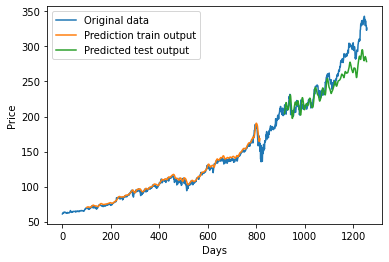

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Original data', 'Prediction train output', 'Predicted test output' ])
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

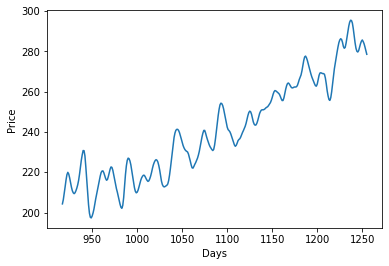

In [ ]:
plt.plot(testPredictPlot)
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

In [ ]:
len(test_predict)

339

In [ ]:
len(test_data) #test_data es la y de los datos de test

440

In [ ]:
x_input=test_data[340:].reshape(1,-1) #obtengo los ultimos 100 dias de los datos de test
x_input.shape


(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

[0.7789436370081531,
 0.7656859269762495,
 0.7738745125841899,
 0.7812477844735908,
 0.798050336760014,
 0.8105636299184686,
 0.8083658277206662,
 0.7994682736618219,
 0.7983339241403757,
 0.7993264799716411,
 0.793690180786955,
 0.7933711449840481,
 0.8015242821694433,
 0.7993619283941862,
 0.8100319035802905,
 0.8098192130450192,
 0.8058135412974121,
 0.79911378943637,
 0.800921658986175,
 0.8110599078341012,
 0.8218362282878411,
 0.8280397022332506,
 0.8226515420063805,
 0.8143211627082594,
 0.8357320099255581,
 0.8626373626373625,
 0.8636653668911731,
 0.8564693371144982,
 0.8543069833392412,
 0.8439560439560436,
 0.8461892945763914,
 0.8599078341013822,
 0.8538461538461537,
 0.8536689117334277,
 0.8512584190003543,
 0.8512229705778092,
 0.8478199220134703,
 0.8479262672811059,
 0.8374335342077277,
 0.8319744771357673,
 0.8365118752215526,
 0.8464374335342078,
 0.8642679900744414,
 0.8656859269762496,
 0.8467210209145692,
 0.8269762495568946,
 0.8287486706841545,
 0.842148174406238

In [ ]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:]) #Descartamos el valor más antiguo y nos quedamos con los 100 ultimos
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1)) #Es necesario para LSTM tener 3 dimensiones
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else: #Aqui solo entra la primera vez
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.7580232]
101
1 day input [0.76568593 0.77387451 0.78124778 0.79805034 0.81056363 0.80836583
 0.79946827 0.79833392 0.79932648 0.79369018 0.79337114 0.80152428
 0.79936193 0.8100319  0.80981921 0.80581354 0.79911379 0.80092166
 0.81105991 0.82183623 0.8280397  0.82265154 0.81432116 0.83573201
 0.86263736 0.86366537 0.85646934 0.85430698 0.84395604 0.84618929
 0.85990783 0.85384615 0.85366891 0.85125842 0.85122297 0.84781992
 0.84792627 0.83743353 0.83197448 0.83651188 0.84643743 0.86426799
 0.86568593 0.84672102 0.82697625 0.82874867 0.84214817 0.84562212
 0.8448777  0.82651542 0.78876285 0.79046437 0.7830911  0.80854307
 0.78730946 0.80733782 0.82275789 0.82892591 0.82892591 0.82672811
 0.82194257 0.83410138 0.85693017 0.86210564 0.87302375 0.8763559
 0.87344913 0.88532435 0.87965261 0.87600142 0.88302021 0.92931585
 0.93349876 0.95926976 0.95129387 0.96462247 0.96770649 0.9763559
 0.97500886 0.97830557 0.97461893 0.95636299 0.96214108 0.97734846
 0.97504431 0.98723857 0.98585608 0.

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

1257

Text(0, 0.5, 'Price')

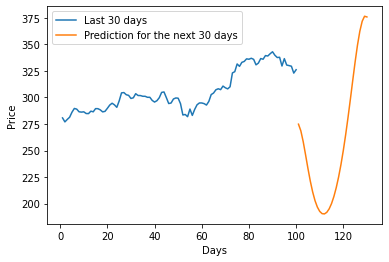

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.legend(['Last 30 days', 'Prediction for the next 30 days'])
plt.xlabel('Days')
plt.ylabel('Price')

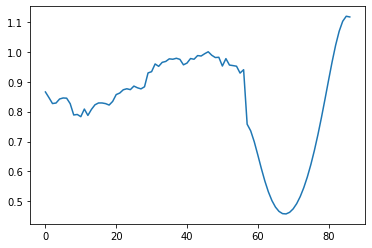

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

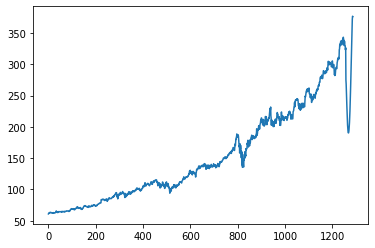

In [ ]:
plt.plot(df3)